# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
24261,33466,78418,"Dublin, Ireland",05-04-2020,"From listed funds to builders to landlords, @k...",Extremely Negative
12864,19401,64353,Ireland,22-03-2020,Subscriber only: Demand for prime cattle is on...,Positive
3262,7745,52697,"Erie, Pa",18-03-2020,The couple earlier this year opened a free gro...,Extremely Positive
26886,36764,81716,"Reston, VA",07-04-2020,ÃÂWe felt compelled to help in any way possi...,Positive


In [3]:
df[df.UserName == 3817]["OriginalTweet"].iloc[0]

'Amazon Glitch Stymies Whole Foods, Fresh Grocery Deliveries\r\r\nÃ\x82Â\x93As COVID-19 has spread, weÃ\x82Â\x92ve seen a significant increase in people shopping online for groceries,Ã\x82Â\x94 a spokeswoman said in a statement. Ã\x82Â\x93Today this resulted in a systems impact affecting our ...\r\r\n https://t.co/TbzZ2MC3b3'

> Ну блин, кто собирал этот файл? Никакой декодер его не справляется прочитать

Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [4]:
df.Sentiment.unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [5]:
df.Sentiment = df.Sentiment.str.endswith("Positive").astype(np.int8)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [6]:
df.Sentiment.value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:**
> Разница примерно в 20%, не очень сбалансировано, конечно...

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [7]:
display(df.isna().sum())
df.fillna("Unknown", inplace=True)

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

> Пропуски были только в поле `Location`

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [49]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)
train: pd.DataFrame
test: pd.DataFrame
display("Train:", train.head())
display("Test:", test.head())

'Train:'

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
25621,35178,80130,Unknown,06-04-2020,Why we still want to buy so much stuff during ...,1
30135,40819,85771,"Boston, MA HQ",10-04-2020,With driving even more usage a strong strategy...,1
28899,39249,84201,India,09-04-2020,@Canon_India I am very happy.. Great job by @C...,1
5989,11068,56020,"Mayfair, London, UK",19-03-2020,The U.S national debt will likely exceed $30 T...,0
4367,9109,54061,WNC,18-03-2020,"Finally got to the grocery store. Honestly, wh...",1


'Test:'

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
28168,38343,83295,London,08-04-2020,What will the post-COVID-19 consumer look like...,1
19874,28015,72967,"Baltimore, MD",26-03-2020,It's crazy how going to the grocery store is s...,0
31702,42798,87750,"Tokyo-to, Japan",12-04-2020,Best online stores to buy things from Tokyo an...,1
5110,10012,54964,Ohio,19-03-2020,#AngelaMerkel Nails #Coronavirus Speech ÃÂ U...,1
30081,40750,85702,"Detroit, MI",10-04-2020,Just saw someone at the grocery store lick the...,0


## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [9]:
from collections import Counter
from typing import Callable

def count_tokens(tokenizer: Callable[[str], list[str]]):
    c = Counter()
    for text in df.OriginalTweet:
        c.update(Counter(tokenizer(text)))
    return pd.Series(c)

token_counts = count_tokens(lambda s: s.lower().split())
token_counts.head()

advice          195
talk            115
to            33447
your           3999
neighbours       24
dtype: int64

Какой размер словаря получился?

In [10]:
token_counts.size

103200

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [11]:
token_counts.sort_values(ascending=False).head(10)

the             38250
to              33447
and             20935
of              18578
a               16667
in              16024
for             12193
#coronavirus    11759
is              10596
are              9958
dtype: int64

**Ответ:**
> Бо́льшая часть токенов в топе &mdash; это просто самые частые слова. Ещё в топе затесался хэштэг `#coronavirus`, но какбэ чего ждать от датасета твитов о коронавирусе))

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [12]:
import nltk
from nltk.corpus import stopwords

stopword_list = stopwords.words('english')
print(stopword_list[:5])
token_counts.drop(index=stopword_list, inplace=True, errors="ignore")
token_counts.sort_values(ascending=False).head(10)

['a', 'about', 'above', 'after', 'again']


#coronavirus    11759
prices           5625
food             5409
grocery          4882
supermarket      4662
covid-19         4504
people           4488
store            4486
#covid19         3561
consumer         3233
dtype: int64

**Ответ:**
> Этот список уже даёт нам представление о содержании корпуса, о наиболее обсуждаемых темах: еда, магазины, цены. Круто!

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [13]:
token_counts.sort_values().head(20)

malik                      1
fled                       1
4.5m                       1
traps.                     1
mismanagement,             1
maduroãâs                1
https://t.co/lwxutheurm    1
#strengthinunity           1
crumbles                   1
https://t.co/nnpmd7s8uw    1
lockdown.....do            1
...hope                    1
@coach_leach               1
https://t.co/jmmbsxjvun    1
#cebu                      1
delata.                    1
silay                      1
naay                       1
watson                     1
cebu,                      1
dtype: int64

**Ответ:**
> Здесь есть ссылки и какие-то странные слова &mdash; это то, что и должно было оказаться на дне. Но ещё сюда попали слова с прилепившейся пунктуацией, это определённо стоит исправить

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [14]:
from nltk.tokenize import TweetTokenizer

tweet_tokenizer = TweetTokenizer()
token_counts = count_tokens(tweet_tokenizer.tokenize)
token_counts.sort_values(ascending=False).head(10)

the    34781
.      34284
to     32812
,      25142
and    20439
of     18429
a      15679
in     15143
?      13730
for    11722
dtype: int64

**Ответ:**
> Из-за специфики токенизатора в топе появилась пунктуация. В остальном в целом всё так же

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [15]:
from string import punctuation

token_counts.drop(index = stopword_list + list(punctuation), inplace=True, errors="ignore")
token_counts.sort_values(ascending=False).head(10)

Â               10498
               10361
#coronavirus    10211
19              10142
I                7484
                6190
prices           6166
COVID            5945
food             5423
store            5234
dtype: int64

**Ответ:**
> В нём есть что-то совсем непохожее на слова. Из-за ошибки кодировки в тексте оказались странные символы, и этот токенизатор выделил их в отдельные слова

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [16]:
token_counts.drop(token_counts[token_counts.index.map(lambda x: len(x) == 1 and ord(x) >= 128)].index, inplace=True)
display("Топ-10 самых популярных слов", token_counts.sort_values(ascending=False).head(10))
display("Топ-20 самых непопулярных слов", token_counts.sort_values().head(20))

'Топ-10 самых популярных слов'

#coronavirus    10211
19              10142
I                7484
prices           6166
COVID            5945
food             5423
store            5234
supermarket      4803
grocery          4350
people           4300
dtype: int64

'Топ-20 самых непопулярных слов'

2eat                       1
https://t.co/4c9qtsun9D    1
@CoStarUKeditorÃ           1
lancaster                  1
https://t.co/L3WL7vMThG    1
#CLE                       1
#CLEResponds               1
https://t.co/XoCCKy9a2O    1
#ClevelandÃ                1
GreaterÃ                   1
@CleveFoundation           1
benefitingÃ                1
purchasesÃ                 1
https://t.co/ElEGBOpDPS    1
#castleton                 1
#rochdale                  1
https://t.co/E0CsuZVEtV    1
#clapfornhs                1
https://t.co/u1vfVIJdTR    1
bellies                    1
dtype: int64

In [17]:
print(token_counts["Lancaster"], token_counts["lancaster"])

1 1


**Ответ:**
> В целом это определённо во многом лучше, чем то, что у нас было. Пунктуация больше не лепится к словам, числа отделяются от привязанных к ним слов. С другой стороны, токенизатор очень избирательно работает с регистром, и в результате вместо двух `lancaster` у нас есть один `lancaster` и один `Lancaster`

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [18]:
token_counts[token_counts.index.str.startswith("#")].sort_values(ascending=False).head(10)

#coronavirus     10211
#COVID19          2621
#Covid_19         2126
#Coronavirus      1806
#COVID2019        1341
#toiletpaper       944
#covid19           829
#COVID             775
#CoronaCrisis      599
#CoronaVirus       525
dtype: int64

**Ответ:**
> Ну что можно сказать... Ожидаемый набор. Ковид, ковид, ковид, ковид, туалетка)))

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [19]:
token_counts[token_counts.index.str.startswith("https://t.co")].sort_values(ascending=False).head(10)

https://t.co/oXA7SWtoNd    6
https://t.co/G63RP042HO    5
https://t.co/WrLHYzIzAA    4
https://t.co/gu6B4XpqP4    4
https://t.co/OI39zSAnQ8    4
https://t.co/3kFUIOJXEp    4
https://t.co/ymsEmlVTTd    4
https://t.co/R7sAGojsjg    4
https://t.co/gP3EusapL8    4
https://t.co/xPcm2Xkj4O    4
dtype: int64

**Ответ:**
> Ну да, ссылки почти не повторяются. Их в целом можно без проблем игнорировать =)

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [20]:
def keep(token: str):
    if token in stopword_list + list(punctuation): return False
    if len(token) == 1 and ord(token) >= 128: return False
    if token.startswith("https://t.co"): return False
    return True

def custom_tokenizer(text: str):
    tokens = tweet_tokenizer.tokenize(text.lower())
    tokens = [t for t in tokens if keep(t)]
    return tokens


In [21]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
cv.fit(train.OriginalTweet)

print(len(cv.vocabulary_))

45290


**Ответ:**
> Словарь более чем в два раза меньше

Посмотрим на какой-нибудь конкретный твитт:

In [23]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [24]:
text = train.iloc[ind]['OriginalTweet']
vector = cv.transform([text])
for token in custom_tokenizer(text):
    print(f"{token}: {vector[0, cv.vocabulary_[token]]}")

nice: 1
one: 1
@skynews: 1
lets: 1
panic: 1
show: 1
ppl: 1
france: 1
queueing: 1
food: 1
#coronavirusoutbreak: 1
#covid2019: 1
brainless: 1
ffs: 1


**Ответ:**
> Ну круто, каждое слово встречается один раз, я это и так знал

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfv = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
tfidfv.fit(train.OriginalTweet)

TfidfVectorizer(token_pattern=None,
                tokenizer=<function custom_tokenizer at 0x0000027B06BE5EE0>)

In [26]:
def token_importance(text):
    vector = tfidfv.transform([text])
    series = pd.Series()
    for token in custom_tokenizer(text):
        series[token] = vector[0, tfidfv.vocabulary_[token]]
    return series

vector = token_importance(text)
print(f"Самый важный токен: {vector.idxmax()} ({vector.max():.2f})")
print(f"Самый неважный токен: {vector.idxmin()} ({vector.min():.2f})")

Самый важный токен: brainless (0.39)
Самый неважный токен: food (0.11)


**Ответ:**
> Ну мне кажется, что очень неплохо. Про еду в наших твитах и так все говорят, а вот слово *brainless* очень хорошо намекает на то, что твит окрашен отрицательно

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [27]:
train[train['OriginalTweet'].apply(lambda x: 'superb' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
18694,26557,71509,Unknown,25-03-2020,@NYGovCuomo Gov.Andrew Cuomo. Peace be with yo...,1
22918,31800,76752,Denver,04-04-2020,queue to get into supermarket Well organised a...,1
22900,31782,76734,"London, UK and Mykonos, Greece",04-04-2020,Lockdown Kitchen Thrift: Fresh herbs ? are a t...,1


In [28]:
text = train[train.UserName == 31782].OriginalTweet.iloc[0]
print(text)

Lockdown Kitchen Thrift: Fresh herbs ? are a typical thing I wasted, because I always needed much less than the bunch on sale and would tire of the taste. Even when I had the sense to freeze them, I ended with black mulch. These two techniques for freezing them are superb:

1/3 https://t.co/c1NNg7oOOG


In [29]:
vector = token_importance(text)
display(vector.sort_values(ascending=False).head(5))
print(f"{vector.idxmax()} ({vector.max():.2f})")

thrift        0.260144
mulch         0.260144
techniques    0.249970
superb        0.242751
herbs         0.232578
dtype: float64

thrift (0.26)


**Ответ:**
> `superb` в топе. На первом месте тоже показательное слово: `thrift` (*экономия*)

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [30]:
cv_X = cv.transform(train.OriginalTweet)
tfidf_X = tfidfv.transform(train.OriginalTweet)
cv_test_X = cv.transform(test.OriginalTweet)
tfidf_test_X = tfidfv.transform(test.OriginalTweet)
y_train = train.Sentiment
y_test = test.Sentiment

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def scores(X_train, X_test):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return accuracy_score(y_train, model.predict(X_train)), accuracy_score(y_test, model.predict(X_test))

fs = "Accuracy на обучающей выборке: %0.3f\nAccuracy на тестовой выборке: %0.3f"
print("CountVectorizer:")
print(fs % scores(cv_X, cv_test_X))
print("TFIDF:")
print(fs % scores(tfidf_X, tfidf_test_X))

CountVectorizer:
Accuracy на обучающей выборке: 0.985
Accuracy на тестовой выборке: 0.867
TFIDF:
Accuracy на обучающей выборке: 0.922
Accuracy на тестовой выборке: 0.853


**Ответ:**
> TF-IDF лох) Хотя наверное CountVectorizer чуть больше переобучился, но TF-IDF в целом тоже

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [32]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")
def custom_stem_tokenizer(text):
  tokens = list(map(stemmer.stem, custom_tokenizer(text)))
  return tokens

In [33]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [34]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
cv.fit(train.OriginalTweet)

print(len(cv.vocabulary_))

36634


**Ответ**
> Размер словаря несколько уменьшился. Это ожидаемо, мы ровно для уменьшения словаря и сделали стемминг. Слова, которые были разными, стали одинаковыми

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [35]:
tfidfv = TfidfVectorizer(tokenizer=custom_stem_tokenizer, token_pattern=None)
tfidfv.fit(train.OriginalTweet)

TfidfVectorizer(token_pattern=None,
                tokenizer=<function custom_stem_tokenizer at 0x0000027B06BE5B20>)

In [36]:
cv_X = cv.transform(train.OriginalTweet)
tfidf_X = tfidfv.transform(train.OriginalTweet)
cv_test_X = cv.transform(test.OriginalTweet)
tfidf_test_X = tfidfv.transform(test.OriginalTweet)

In [37]:
print("CountVectorizer:")
print(fs % scores(cv_X, cv_test_X))
print("TFIDF:")
print(fs % scores(tfidf_X, tfidf_test_X))

CountVectorizer:
Accuracy на обучающей выборке: 0.972
Accuracy на тестовой выборке: 0.867
TFIDF:
Accuracy на обучающей выборке: 0.917
Accuracy на тестовой выборке: 0.856


**Ответ:**
> Результаты на тестовой выборке остались такими же. С другой стороны, видимо, эти модели чуть меньше переобучаются, что может быть преимуществом

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [38]:
train.shape[0]

23410

In [39]:
dt_matrix = cv.transform(train.OriginalTweet)

In [42]:
docfreq = pd.Series(np.arange(dt_matrix.shape[1])).map(lambda i: dt_matrix.getcol(i).count_nonzero()).sort_values(ascending=False)
docfreq.iloc[0]

8761

In [40]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        token_pattern=None,
                        max_df=8760
                        ).fit(train.OriginalTweet)
print(len(cv_df.vocabulary_))

36633


**Ответ:**
> `max_df` &mdash; примерно треть от общего числа документов. Кажется, это вполне ожидаемо для самого частого слова кроме стоп-слов в тематическом датасете

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [43]:
docfreq.iloc[3700]

10

In [44]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        token_pattern=None,
                        min_df=11,
                        ).fit(train.OriginalTweet)
print(len(cv_df.vocabulary_))

3687


In [45]:
cv_df_X = cv_df.transform(train.OriginalTweet)
cv_df_test_X = cv_df.transform(test.OriginalTweet)
print(fs % scores(cv_df_X, cv_df_test_X))

Accuracy на обучающей выборке: 0.929
Accuracy на тестовой выборке: 0.868


**Ответ:**
> `min_df` = 11, вполне естественная граница: не слишком высокая, но достаточная, чтобы отбросить всякий мусор.
> 
> Вновь accuracy на обучающей выборке уменьшилось с сохранением accuracy на тестовой.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)

def train_report(X_train, X_test):
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model = LogisticRegression(max_iter=10_000)
    train_predict = model.fit(X_train, y_train).predict(X_train)
    test_predict = model.predict(X_test)
    print(fs % (accuracy_score(y_train, train_predict), accuracy_score(y_test, test_predict)))
    return model

model = train_report(cv_df_X, cv_df_test_X)

Accuracy на обучающей выборке: 0.941
Accuracy на тестовой выборке: 0.845


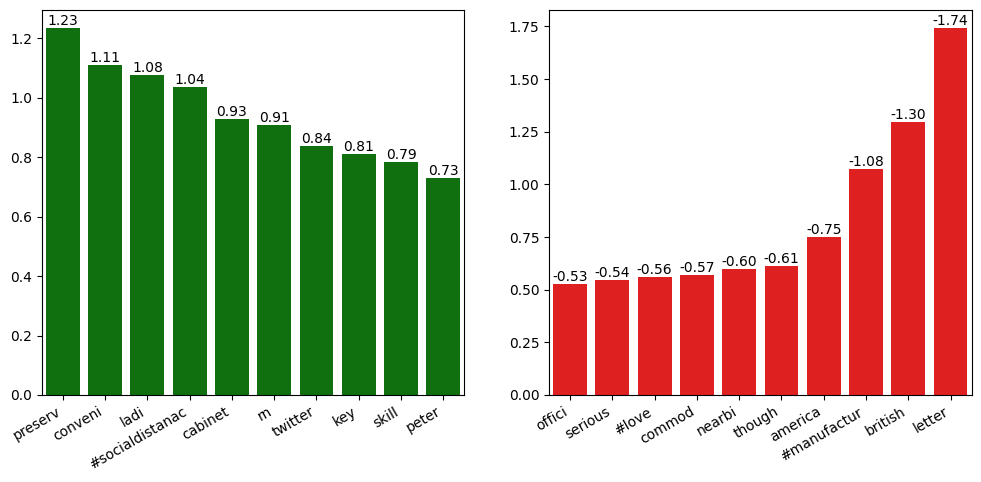

In [ ]:
from matplotlib.axes import Axes
coefs = pd.Series(model.coef_[0], index=cv_df.vocabulary_).sort_values(ascending=False)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1: Axes
ax2: Axes

top = coefs[:10]
bars = sns.barplot(top, ax=ax1, color="g")
ax1.set_xticks(ticks=ax1.get_xticks(), labels=ax1.get_xticklabels(), rotation=30, ha="right")
ax1.bar_label(bars.containers[0], top.map(lambda f: f'{f:.2f}'))

top = coefs[-10:]
bars = sns.barplot(top.abs(), ax=ax2, color="r")
ax2.set_xticks(ticks=ax2.get_xticks(), labels=ax2.get_xticklabels(), rotation=30, ha="right")
ax2.bar_label(bars.containers[0], top.map(lambda f: f'{f:.2f}'))

plt.show()

**Ответ:**
> Брээээ, мы деградировали. Возможно, проблема в том, что в скалировании нельзя отцентрировать данные из-за того что параметры хранятся в `sparse matrix`
> 
> Коэффициенты, если честно, вообще непрозрачные. Разве что положительные *preserv* и *skill* и отрицательное *serious* имеют смысл, остальное вообще неочевидно. Ну, чтош. Моделька что-то себе придумала, и вот получите распишитесь

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
display(df[["UserName", "ScreenName"]].describe())
username_counts = df.UserName.value_counts()
screenname_counts = df.ScreenName.value_counts()
print(username_counts[username_counts > 1].shape[0])
print(screenname_counts[screenname_counts > 1].shape[0])

,UserName,ScreenName
count,33444.000000,33444.000000
mean,24233.721863,69185.721863
std,11875.552641,11875.552641
min,3800.000000,48752.000000
25%,13964.750000,58916.750000
50%,24159.500000,69111.500000
75%,34514.250000,79466.250000
max,44955.000000,89907.000000


0
0


**Ответ:**
> Это просто случайные числа, они даже не повторяются, так что мы не сможем никак опираться на личность автора твита

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

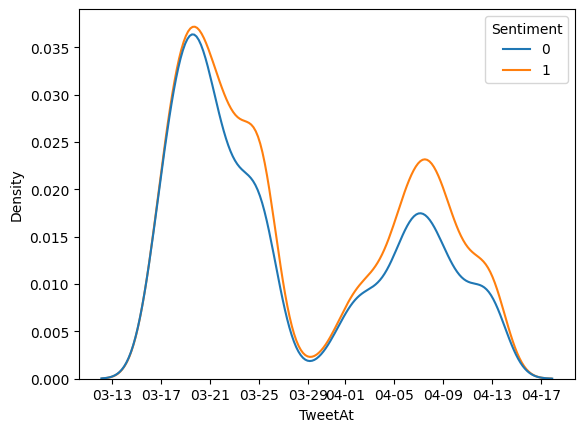

In [ ]:
tweet_at = pd.to_datetime(df.TweetAt, dayfirst=True)
sns.kdeplot(pd.concat([tweet_at, df.Sentiment], axis=1), x="TweetAt", hue="Sentiment")
ticks, labels = plt.xticks()
plt.xticks(ticks=ticks, labels=[l.get_text()[5:] for l in labels])
plt.show()

**Ответ:**
> Нууу не похоже, что дата сильно на что-то влияет, но есть пара промежутков где положительных отзывов становится больше, так что давайте допустим включим этот параметр в рассмотрение

In [50]:
train.TweetAt = pd.to_numeric(pd.to_datetime(train.TweetAt, dayfirst=True), downcast="float")
test.TweetAt = pd.to_numeric(pd.to_datetime(test.TweetAt, dayfirst=True), downcast="float")
train.TweetAt.iloc[0]

1.5861312e+18

In [51]:
c: int = 10 ** np.floor(np.log10(train.TweetAt)).min()
train.TweetAt = train.TweetAt / c
test.TweetAt = test.TweetAt / c
train.TweetAt.iloc[0]

1.5861312

In [56]:
from scipy import sparse

cv_df_X_w_date = sparse.hstack((cv_df_X, train[["TweetAt"]]))
cv_df_test_X_w_date = sparse.hstack((cv_df_test_X, test[["TweetAt"]]))

model = train_report(cv_df_X_w_date, cv_df_test_X_w_date)

Accuracy на обучающей выборке: 0.941
Accuracy на тестовой выборке: 0.845


> Ну лан, действительно бесполезный параметр

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [60]:
train.Location.unique().size

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

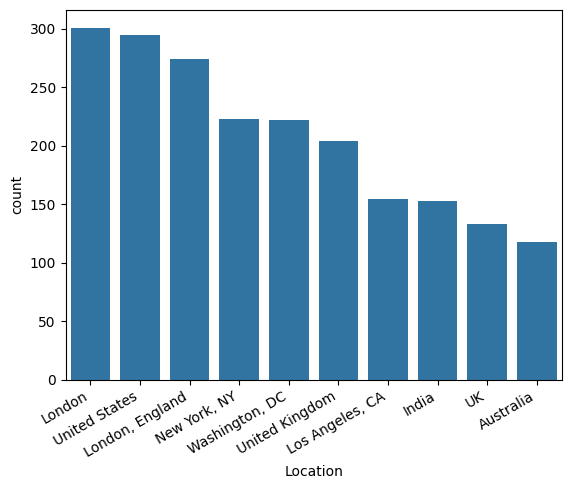

In [64]:
sns.barplot(train.Location.value_counts().sort_values(ascending=False).drop("Unknown")[:10])
plt.xticks(rotation=30, ha="right")
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [79]:
def wider_location(s: str): return s.rsplit(",", maxsplit=1)[-1].strip() if ":" not in s else s
train["WiderLocation"] = train.Location.apply(wider_location)
test["WiderLocation"] = test.Location.apply(wider_location)
train.WiderLocation.unique().size

4634

> Ну нехило так, на 30%+ сжалось

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [80]:
loc_counts = train.WiderLocation.value_counts()
loc_counts[loc_counts > 1].size

989

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [87]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories=[loc_counts[loc_counts>1].index.tolist()], handle_unknown="ignore")
cv_df_X_w_loc = sparse.hstack((cv_df_X, encoder.fit_transform(train[["WiderLocation"]])))
cv_df_test_X_w_loc = sparse.hstack((cv_df_test_X, encoder.transform(test[["WiderLocation"]])))

model = train_report(cv_df_X_w_loc, cv_df_test_X_w_loc)

Accuracy на обучающей выборке: 0.955
Accuracy на тестовой выборке: 0.834


**Ответ:**
> Ничего толком не изменилось. На обучающей выборке accuracy увеличилась, на тренировочной уменьшилась, но опять же всё в рамках погрешности
>
>
> Всё тлен